This notebook outlines some quality control measures for the mTurk survey data.

In [66]:
import os,glob,json
import numpy,pandas
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt

%matplotlib inline

Load the datafiles and check for bad items. Note that the one level mismatch is due to averaging of two presentation of a single item.

In [2]:
datafiles=glob.glob('surveydata/*survey.tsv')

skewness={}
unused={}
mismatch={}
lowfreq={}
low_thresh=0.01

for f in datafiles:
    d=pandas.read_csv(f,delimiter='\t',index_col=0)
    mdfile=f.replace('.tsv','.json').replace('surveydata','metadata')
    with open(mdfile) as md:
        metadata = json.loads(md.read())
    for c in d.columns:
        assert c in metadata
        levels=[l.replace(' ','') for l in metadata[c]['Levels'].keys()]
        if  len(levels)<len(d[c].unique()):
            print('level mismatch:',c,levels,d[c].unique())
            mismatch[c]=(levels,d[c].unique())
            continue
        if  len(levels)>len(d[c].unique()):
            #print('unused levels:',c,levels,d[c].unique())
            unused[c]=(levels,d[c].unique())
        nvals=[]
        for datalevel in d[c].unique():
            if not '%d'%datalevel in levels:
                print(c,datalevel,'not in',levels)
            nvals.append((d[c]==datalevel).sum())
        nvals=numpy.array(nvals)
        nvals=nvals/numpy.sum(nvals)
        bcut=numpy.where(nvals<low_thresh)[0]
        if len(bcut)>0:
            for bc in bcut:
                #print('%s: p(%s)=%f'%(c,levels[bc],nvals[bc]))
                lowfreq[c]=(levels[bc],nvals[bc])


level mismatch: self_regulation_survey_26 ['2', '3', '5', '1', '4'] [ 4.   5.   3.5  4.5  3.   1.5  2.5  2.   1. ]


In [65]:
print('found %d items with a response present for less than %d percent of subjects'%(len(lowfreq),int(low_thresh*100)))
print('found %d items with at least 1 unused response'%len(unused))

found 56 items with a response present for less than 1 percent of subjects
found 42 items with at least 1 unused response


Now let's look for outlier subjects.  Simple approach here is to compute first two principal components, and see which subjects fall more than 3 SD's from the crowd.  There are almost certainly better approaches - e.g. http://stats.stackexchange.com/questions/213/what-is-the-best-way-to-identify-outliers-in-multivariate-data

Subjects more than 3 SD on either PCA component
s202 0.339441953505 -3.41390719533


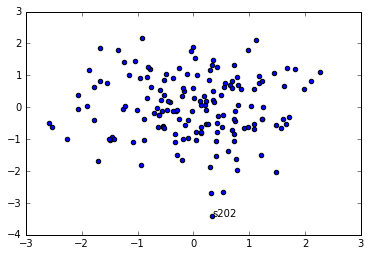

In [74]:
alldata=pandas.read_csv('surveydata.csv',index_col=0)
pca=PCA(n_components=2,whiten=True)
pca_result=pca.fit_transform(alldata)
plt.scatter(pca_result[:,0],pca_result[:,1])
possible_outliers=numpy.where(numpy.max(numpy.abs(pca_result),1)>3)[0]
print('Subjects more than 3 SD on either PCA component')
for p in possible_outliers:
    plt.text(scaled_result[p,0],scaled_result[p,1],alldata.index[p])
    print(alldata.index[p],scaled_result[p,0],scaled_result[p,1])
